In [1]:
from scripts import bookdatafunctions as bdf
import pandas as pd
import seaborn as sns
import matplotlib
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
#Constants
DEPRELS = ['root', 'nsubj', 'advmod', 'obl', 'obj', 'conj', 'aux', 'cc', 'amod', 'nmod:poss', 'mark', 'cop', 'nsubj:cop', 'advcl', 'xcomp', 'case', 'det', 'ccomp', 'nmod', 'parataxis', 'acl:relcl', 'acl', 'xcomp:ds', 'discourse', 'nummod', 'fixed', 'cop:own', 'appos', 'flat:name', 'compound:nn', 'aux:pass', 'vocative', 'nmod:gobj', 'nmod:gsubj', 'compound:prt', 'csubj:cop', 'flat:foreign', 'orphan', 'cc:preconj', 'csubj', 'compound', 'flat', 'goeswith']

CASES = ['Case=Nom', 'Case=Gen', 'Case=Par', 'Case=Ill', 'Case=Ine', 'Case=Ela', 'Case=Ade', 'Case=All', 'Case=Ess', 'Case=Abl', 'Case=Tra', 'Case=Acc', 'Case=Ins', 'Case=Abe', 'Case=Com']

VERBFORMS = ['VerbForm=Fin', 'VerbForm=Inf', 'VerbForm=Part']

VERBVOICES = ['Voice=Act', 'Voice=Pass']

VERBMOODS = ['Mood=Ind', 'Mood=Cnd', 'Mood=Imp']

POS = ['NOUN', 'VERB', 'PRON', 'ADV', 'AUX', 'ADJ', 'PROPN', 'CCONJ', 'SCONJ', 'ADP', 'NUM', 'INTJ']

ALL_FEATS = DEPRELS + CASES + VERBFORMS + VERBVOICES + VERBMOODS + POS

ISBN2AGE_PATH = "ISBN2AGE/ISBN2AGE.xlsx"

In [4]:
#Nab corpus and transform ages
corpus = bdf.mapGroup2Age(bdf.cleanWordBeginnings(bdf.cleanLemmas(bdf.initBooksFromConllus("Conllus"))), ISBN2AGE_PATH)

In [5]:
#Define sub-corpora

ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
ages_str = list(map(str, ages))
ages_span_2_str = [ages_str[i]+"_"+ages_str[i+1] for i in range(len(ages_str)-1)]
ages_span_3_str = [ages_str[i-1]+"_"+ages_str[i]+"_"+ages_str[i+1] for i in range(1, len(ages_str)-1)]
#Distinct ages
sub_span_1 = [bdf.getDistinctSubCorp(corpus, x) for x in ages]
#Sliding window with span 1 (so 5&6, 6&7, etc.) 
sub_span_2 = [bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x), bdf.getDistinctSubCorp(corpus, x+1)]) for x in ages if (x < 15)]
#Sliding window with span 2 (so 5&6&7, 6&7&8, etc.)
sub_span_3 = [bdf.combineSubCorpDicts([bdf.getRangeSubCorp(corpus, x)]) for x in ages if (5 < x < 15)]

In [6]:
#Combine info into dicts for easier usage
sub_corps_1 = dict(zip(ages_str, sub_span_1))
sub_corps_2 = dict(zip(ages_span_2_str, sub_span_2))
sub_corps_3 = dict(zip(ages_span_3_str, sub_span_3))

In [29]:
effect_sizes_1 = {}
for sub1 in sub_corps_1:
    for sub2 in sub_corps_1:
        new_key = str(sub1)+"+"+str(sub2)
        effect_sizes = []
        for deprel in DEPRELS:
            effect_sizes.append( bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_corps_1[sub1], deprel, True), bdf.getDeprelFeaturePerBook(sub_corps_1[sub2], deprel, True)) )
        for ctg in [CASES, VERBFORMS, VERBMOODS, VERBVOICES]:
            for feat in ctg:
                effect_sizes.append( bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_corps_1[sub1], feat, True), bdf.getFeatsFeaturePerBook(sub_corps_1[sub2], feat, True)) )
        for pos in POS:
            effect_sizes.append( bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_corps_1[sub1], pos, True), bdf.getPosFeaturePerBook(sub_corps_1[sub2], pos, True)) )
        effect_sizes_1[new_key] = effect_sizes

In [32]:
ef_1_df = pd.DataFrame(effect_sizes_1, index=ALL_FEATS)

In [7]:
effect_sizes_3 = {}
with tqdm(range(len(list(sub_corps_3.keys()))**2), desc="Iterating over subcorpora...") as pbar:
    for key1 in sub_corps_3:
        sub_corpus_1 = sub_corps_3[key1]
        for key2 in sub_corps_3:
            sub_corpus_2 = sub_corps_3[key2]
            new_key = str(key1)+"+"+str(key2)
            effect_sizes = []
            for deprel in DEPRELS:
                effect_sizes.append( bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_corpus_1, deprel, True), bdf.getDeprelFeaturePerBook(sub_corpus_2, deprel, True)) )
            for ctg in [CASES, VERBFORMS, VERBMOODS, VERBVOICES]:
                for feat in ctg:
                    effect_sizes.append( bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_corpus_1, feat, True), bdf.getFeatsFeaturePerBook(sub_corpus_2, feat, True)) )
            for pos in POS:
                effect_sizes.append( bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_corpus_1, pos, True), bdf.getPosFeaturePerBook(sub_corpus_2, pos, True)) )
            effect_sizes_3[new_key] = effect_sizes
            pbar.update(1)

Iterating over subcorpora...: 100%|██████████| 81/81 [50:30<00:00, 37.41s/it]


<Axes: >

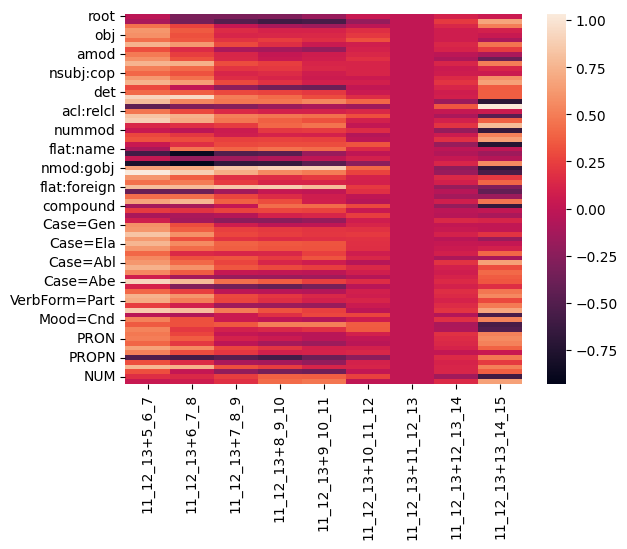

In [22]:
ef_3_df = pd.DataFrame(effect_sizes_3, index=ALL_FEATS)

def sub_columns(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

sns.heatmap(ef_3_df[sub_columns(ef_3_df.columns, '11')])

In [46]:
print(ef_1_df['5+6'].sort_values())

orphan          -1.773328
advmod          -1.272830
ADV             -1.221389
xcomp           -1.165279
VerbForm=Part   -1.130718
                   ...   
parataxis        2.096790
PROPN            2.170781
discourse        2.334428
INTJ             2.380276
dep                   NaN
Name: 5+6, Length: 79, dtype: float64


In [47]:
test_df = ef_1_df.copy()
print(test_df.index)
test_df = test_df.drop(['NUM', 'dep'])
print(test_df.index)

Index(['root', 'nsubj', 'advmod', 'obl', 'obj', 'conj', 'aux', 'cc', 'amod',
       'nmod:poss', 'mark', 'cop', 'nsubj:cop', 'advcl', 'xcomp', 'case',
       'det', 'ccomp', 'nmod', 'parataxis', 'acl:relcl', 'acl', 'xcomp:ds',
       'discourse', 'nummod', 'fixed', 'cop:own', 'appos', 'flat:name',
       'compound:nn', 'aux:pass', 'vocative', 'nmod:gobj', 'nmod:gsubj',
       'compound:prt', 'csubj:cop', 'flat:foreign', 'orphan', 'cc:preconj',
       'csubj', 'compound', 'flat', 'goeswith', 'dep', 'Case=Nom', 'Case=Gen',
       'Case=Par', 'Case=Ill', 'Case=Ine', 'Case=Ela', 'Case=Ade', 'Case=All',
       'Case=Ess', 'Case=Abl', 'Case=Tra', 'Case=Acc', 'Case=Ins', 'Case=Abe',
       'Case=Com', 'VerbForm=Fin', 'VerbForm=Inf', 'VerbForm=Part',
       'Voice=Act', 'Voice=Pass', 'Mood=Ind', 'Mood=Cnd', 'Mood=Imp', 'NOUN',
       'VERB', 'PRON', 'ADV', 'AUX', 'ADJ', 'PROPN', 'CCONJ', 'SCONJ', 'ADP',
       'NUM', 'INTJ'],
      dtype='object')
Index(['root', 'nsubj', 'advmod', 'obl', 'obj'

In [51]:
def sub_columns(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

<Axes: >

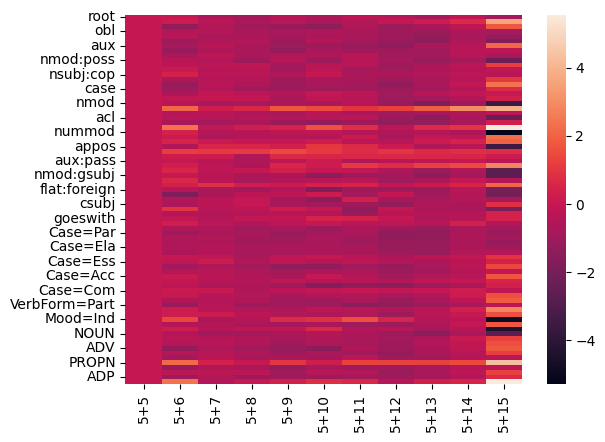

In [ ]:
sns.heatmap(test_df[sub_columns(test_df.columns, '5')])

<Axes: >

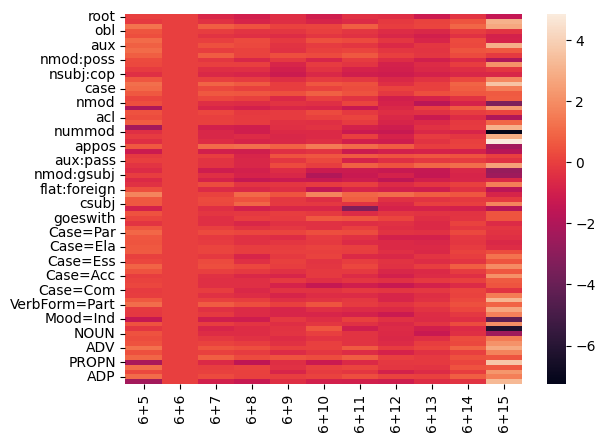

In [53]:
sns.heatmap(test_df[sub_columns(test_df.columns, '6')])